# Data setup 

In [27]:
# initialize data 
###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s

def data_from_file(file_name):
    data = np.loadtxt(file_name)
    ids = data[0, :]    
    dfs = data[1:, :]
    iqs = list(range(180, -1, -10))
    xLabel = 'd-axis current - Id [A]'
    yLabel = 'Direct flux linkage [Wb]'
    Is = 'Iq '
    return ids, dfs, iqs, Is, xLabel, yLabel


ids, dfs, iqs, Is, xLabel, yLabel = data_from_file('PMASynRM_input_data/D_d_madalina.txt')

print('iqs', iqs)
print('ids', ids)
print('flux', Flux.shape)

iqs [180, 170, 160, 150, 140, 130, 120, 110, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
ids [   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.]


NameError: name 'Flux' is not defined

# [REDUCE CURRENTS] Represent original curves for different iqs values

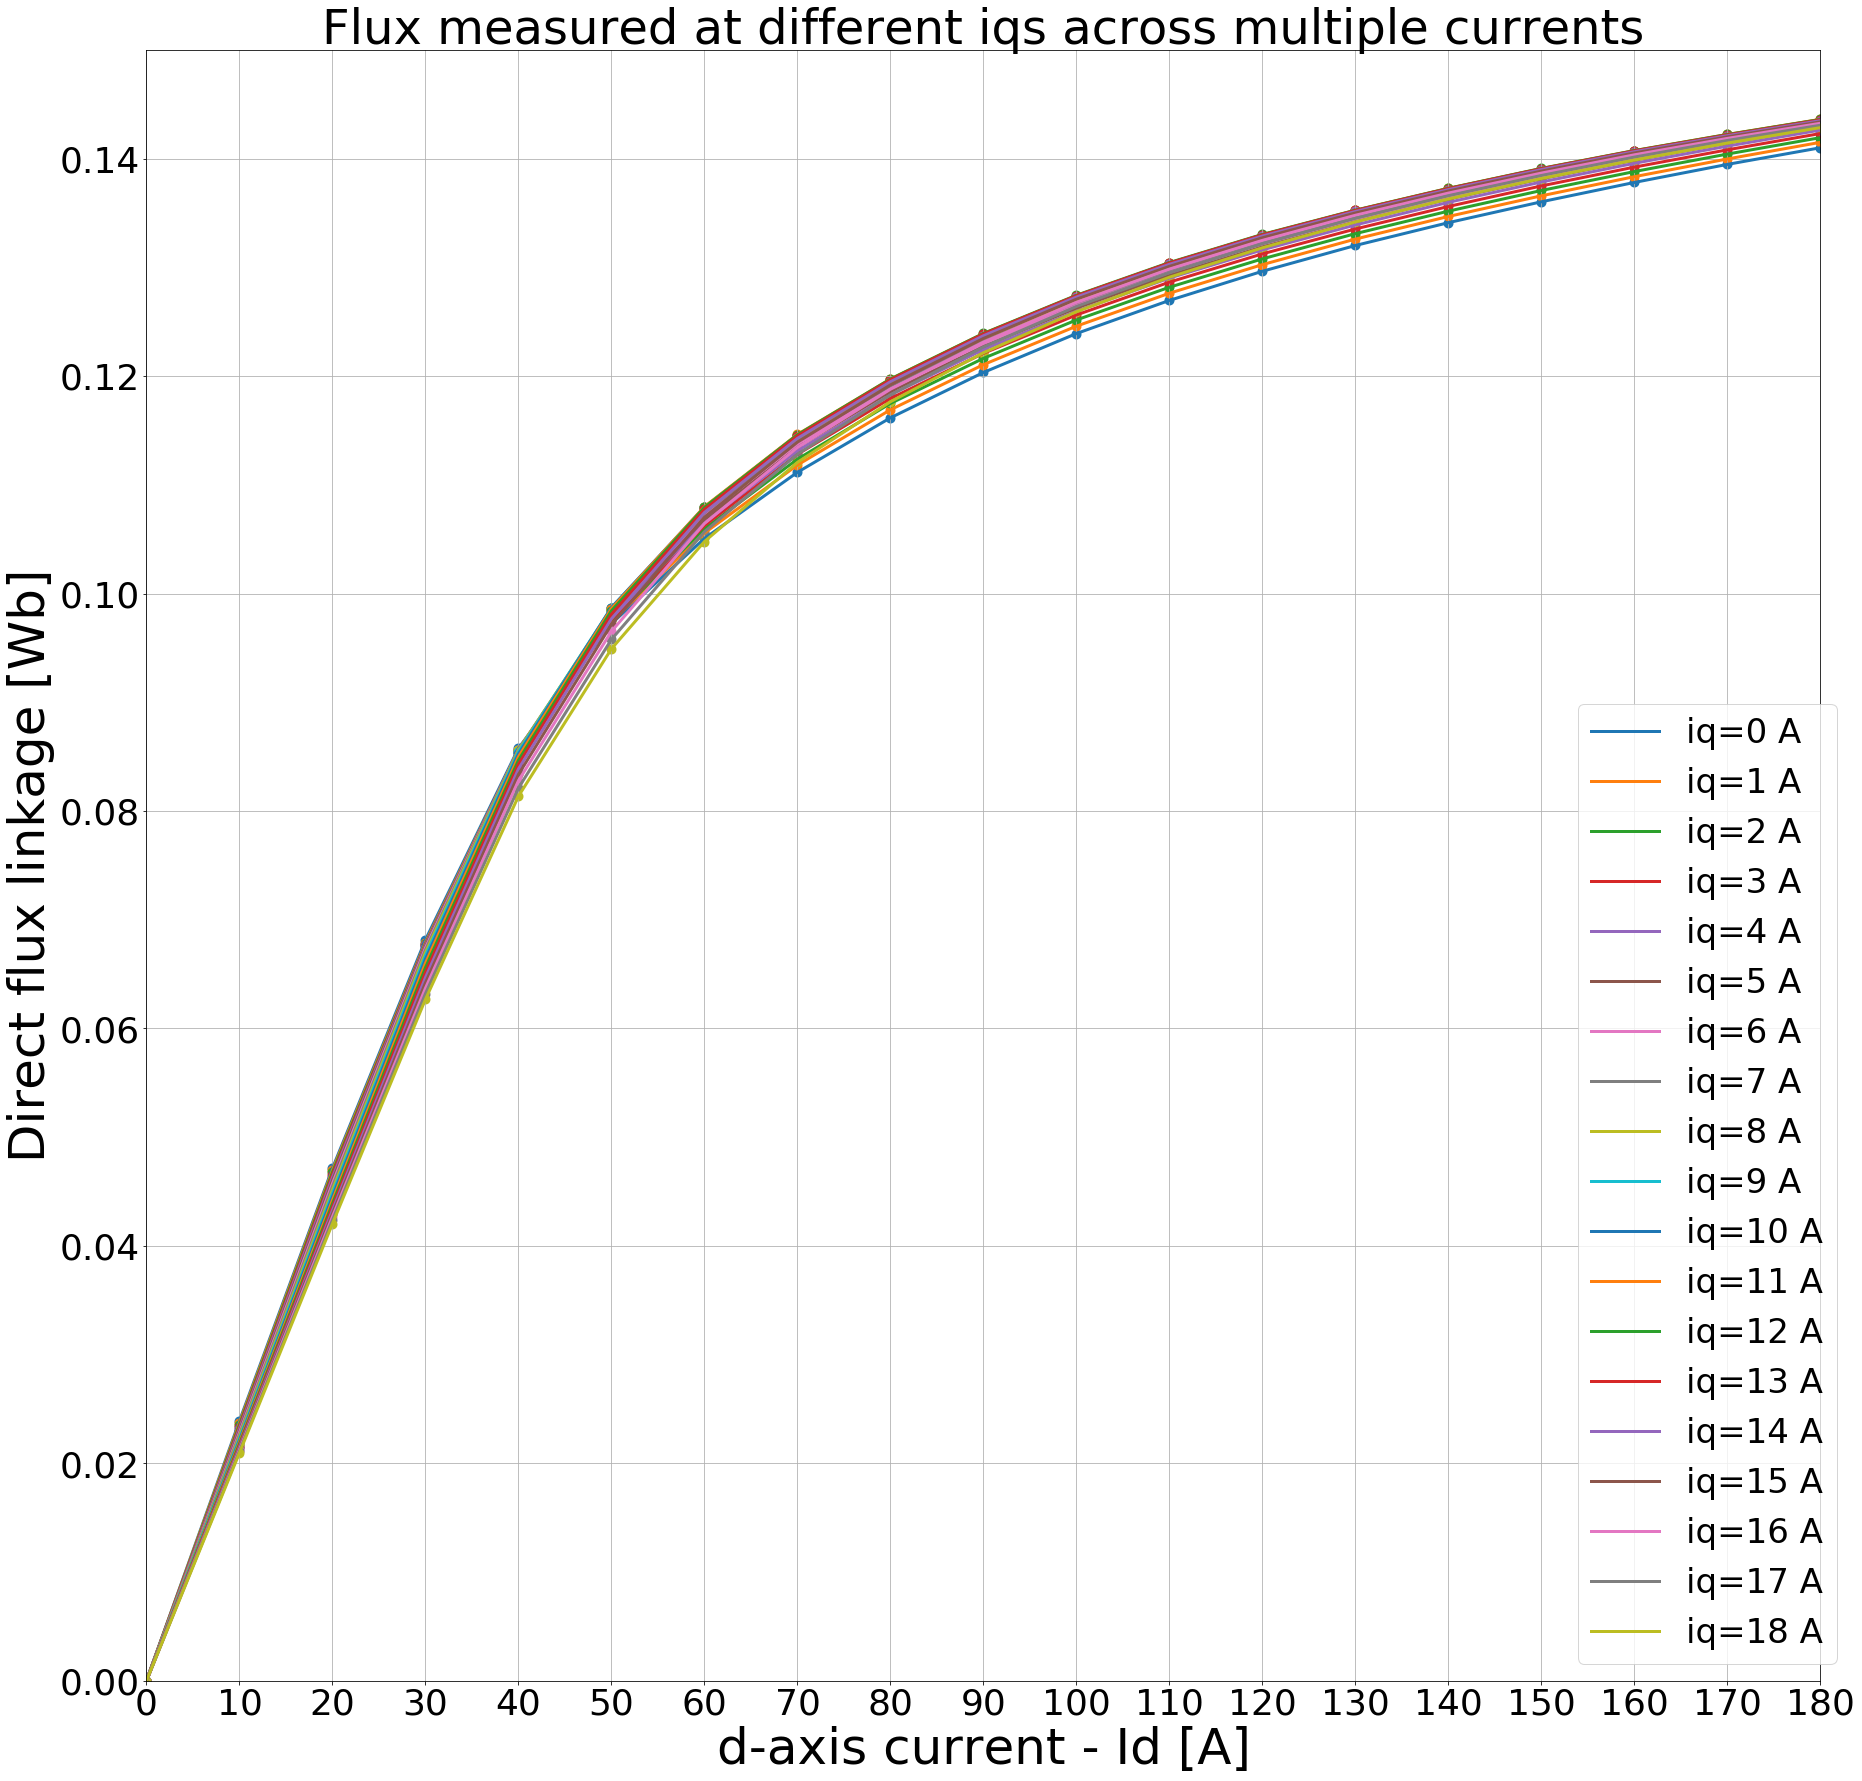

In [13]:
## from subprocess import call

flux = np.copy(Flux)

plt.figure(figsize=[30,30])

for idx in range(len(iqs)):
    df =flux[:,idx]
    plt.plot(ids, df, linewidth=3, label= 'iq=%d A' %(idx))
    plt.scatter(ids,df, linewidths=4)
    plt.ylim([0,0.15])
    plt.xlim([0, 3])
    plt.xticks(ids, fontsize=36)
    plt.yticks(fontsize=36)
    plt.xlabel(xLabel, fontsize = 50)
    plt.ylabel(yLabel, fontsize = 50)
    plt.title('Flux measured at different iqs across multiple currents', fontsize=48)
    plt.legend(bbox_to_anchor=(1.02, 0), loc='lower right', ncol=1, fontsize=34)
plt.grid()
plt.savefig('test_output/SRM_original_curves_across_currents.pdf', dpi = 200)
plt.show()

In [ ]:
#
import numpy as np
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing

#preprocess the data
X = np.copy(Flux)
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(X)
no_of_comps = range(2, 14)

errors = []
for comp in no_of_comps:
    pca_reduce_points = PCA(n_components=comp)
    flux_reduced = pca_reduce_points.fit_transform(df_flux_scaled)
    projected  = pca_reduce_points.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)
    errors.append(np.sum((projected_unscaled - X) ** 2))
print('components shape: ', pca_reduce_points.components_.shape)

plt.figure(figsize=(10, 10))
plt.xlabel('No of Principal Components', fontsize = 14)
plt.ylabel('Reconstruction error ', fontsize = 14)
plt.xlim([0,14])
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.locator_params(axis='x', nbins=len(no_of_comps))
plt.scatter(no_of_comps, errors)
plt.plot(no_of_comps, errors, linewidth=3)
plt.grid()
plt.title('PCA for reducing number of currents', fontsize=16)
plt.savefig('test_output/SRM_reduce_currents_PCA_errors.pdf', dpi = 200)
plt.show()



# [REDUCE CURRENTS] Find currents with highest variance and choose top n
- Alegem sa zicem 6. Stim din plotul de mai sus ca 6 curenti ne dau eroare de reconstructie suficienta
- Am avut nevoie de PCA ca sa imi aleg n, avand o imagine despre cat o sa pierd

In [15]:
# from sklearn.linear_model import Ridge
from pandas import DataFrame as df
import csv

X = np.copy(Flux)
variance = np.var(X, axis=0)

currents_variance = sorted(zip(ids, variance), key=lambda e : e[1], reverse=True)
border_currents = [e for e in currents_variance if e[0] == min(ids)] + [e for e in currents_variance if e[0] == max(ids)]
non_border_currents = [e for e in currents_variance if e not in border_currents]

def get_top_currents(currents_no):
    top_currents = sorted([e[0] for e in currents_variance[:currents_no]])
    return top_currents

def get_top_currents_bordered(currents_no):
    assert(currents_no >= 2)
    top_currents = border_currents + non_border_currents[:currents_no-2]
    return sorted([e[0] for e in top_currents])

top_n = range(2, len(ids))

print('CURRENTS WITH HIGHEST VARIANCE')
for n in top_n:
    top_n_curents = get_top_currents(n)
    print('top %2d currents' % n, top_n_curents)
print('\n')

print('CURRENTS WITH HIGHEST VARIANCE -- always including max/min (0.2, 2.6) -- because spline needs limit values')
for n in top_n:
    top_n_curents = get_top_currents_bordered(n)
    print('top %2d currents' % n, top_n_curents)


CURRENTS WITH HIGHEST VARIANCE
top  2 currents [150.0, 160.0]
top  3 currents [140.0, 150.0, 160.0]
top  4 currents [140.0, 150.0, 160.0, 170.0]
top  5 currents [130.0, 140.0, 150.0, 160.0, 170.0]
top  6 currents [130.0, 140.0, 150.0, 160.0, 170.0, 180.0]
top  7 currents [120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0]
top  8 currents [110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0]
top  9 currents [100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0]
top 10 currents [90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0]
top 11 currents [80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0]
top 12 currents [70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0]
top 13 currents [60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0]
top 14 currents [50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0]
top 15 currents [40.0, 50.0, 60.0, 

## [REDUCE CURRENTS] We measure the flux value in key top n curents and then use linear interpolation to predict flux across all curents 
- am schimbat de la cubic spline la linear pt ca merge mai bine. Justificarea e ca ai treapta aia, are shape mai degraba in trepte decat in curbe.
- plot Interpolation error as a function of the number of points used as basis per each curve
- we expect to get the same shape like in PCA reconstruction (first plot)

In [ ]:
from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from subprocess import call
from pandas import DataFrame as df

X = np.copy(Flux)
# print(X.shape)

#initialize plot size
# plt.figure(figsize=[30,30])
# plt.rcParams['figure.figsize'] = (30,30)

def get_index(vec, e):
    for i in range(len(vec)):
        if e == vec[i]:
            return i
    assert(False)

def compare_curve_with_interp(curve, n, top_n_function, title):
    top_n_curents = top_n_function(n)
    top_n_curents_indices = [get_index(ids, c) for c in top_n_curents]
    plt.figure(figsize=(10, 10))
    x = ids 
    baseline = X[curve, :] 
    plt.plot(x, baseline, c='b', label = 'Original curve')
    plt.scatter(x, baseline, c='b')
    x_ = top_n_curents
    y_ = X[curve, top_n_curents_indices]
    tck_ = interpolate.splrep(x_, y_, k=1)
    y = interpolate.splev(x, tck_) 
    error = np.sum((y - baseline)**2)
    
    ## preprocess the title for the saved graphic file
    tmp = top_n_function.__name__
    ana = tmp.split('_')
    if ana[-1] == 'bordered':
        flag = 'with_border_points'
    else:
        flag = 'no_border_points'
   
    
    plt.scatter(x_, y_, c='r')
    plt.plot(x, y, c='g', label = 'Interpolation plot')
    plt.title('%s \n error=%.4f' % (title, error), fontsize=20)
    plt.xlabel(xLabel, fontsize = 20)
    plt.ylabel(yLabel, fontsize = 20)
    plt.legend(loc='best', fontsize = 18)
    plt.grid()
    plt.savefig('test_output/SRM_reduce_currents_interp_Iq=%d°_%d_pts_%s.pdf' %(curve, n, flag))
    plt.show()
    return error

print('COMPARE INTERPOLATION WITH/ WITHOUT DEFINED BORDERS')
n = 5
curve = 12
compare_curve_with_interp(curve, n, get_top_currents, 
                'Iq=%d° \n currents_no = %d pts \n NO including border points' % (iqs[curve], n))
compare_curve_with_interp(curve, n, get_top_currents_bordered, 
                'Iq=%d° \n currents_no = %d pts \n including border points' % (curve, n))


print('COMPARE INTERPOLATION WITH DIFF NUMBER of POINTS as basis')


n = 2
curve = 12
compare_curve_with_interp(curve, n, get_top_currents_bordered, 
                ' Iq=%d° \n currents_no = %d pts \n including border points' % (curve, n))
n = 5
curve = 12
compare_curve_with_interp(curve, n, get_top_currents_bordered, 
                'Iq=%d° \n currents_no = %d pts \n including border points' % (curve, n))
n = 7
curve = 12
compare_curve_with_interp(curve, n, get_top_currents_bordered, 
                'Iq=%d° \n currents_no = %d pts \n including border points' % (curve, n))
n = 9
curve = 12
compare_curve_with_interp(curve, n, get_top_currents_bordered, 
                'Iq=%d° \n currents_no = %d pts \n including border points' % (curve, n))


# [REDUCE CURRENTS] Plot reconstruction Error of Interpolation

In [ ]:
from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from pandas import DataFrame as df

X = np.copy(Flux)
print(X.shape)

top_n = range(2, len(ids))
errors = []
for n in top_n:
    top_n_curents = get_top_currents_bordered(n)
    top_n_curents_indices = [get_index(ids, c) for c in top_n_curents]
    error = 0
    for curve in range(X.shape[0]):
        # baseline = y values obtained when interpolating with all ground truth points
        x = ids 
        baseline = X[curve, :] 

        # interpolate with top_n_currents as basis 
        x_ = top_n_curents
        y_ = X[curve, top_n_curents_indices]
        tck_ = interpolate.splrep(x_, y_, k=1)
        y = interpolate.splev(x, tck_) 
        
        # error -- difference between baseline interp curve and current one
        error += np.sum((baseline - y)**2) /  baseline.shape[0]
    errors.append(error / X.shape[0])
            
plt.figure(figsize=(10, 10))
plt.xlabel('Top n currents', fontsize = 14)
plt.ylabel('Interpolation error ', fontsize = 14)
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.locator_params(axis='x', nbins=len(top_n))
plt.scatter(top_n, errors)
plt.plot(top_n, errors, linewidth=3)
plt.grid()
plt.title('Interpolation error while reducing number of currents', fontsize=16)
plt.savefig('test_output/SRM_reduce_currents_interpolation_errors.pdf', dpi = 200)
plt.show()


# [REDUCE ANGLES] Reducing the number of curves - iqs
- fix aceeasi logica ca mai sus dar transpui inputul

- vezi mai jos ce inseamna un sample

# [REDUCE ANGLES] Represent original curves 

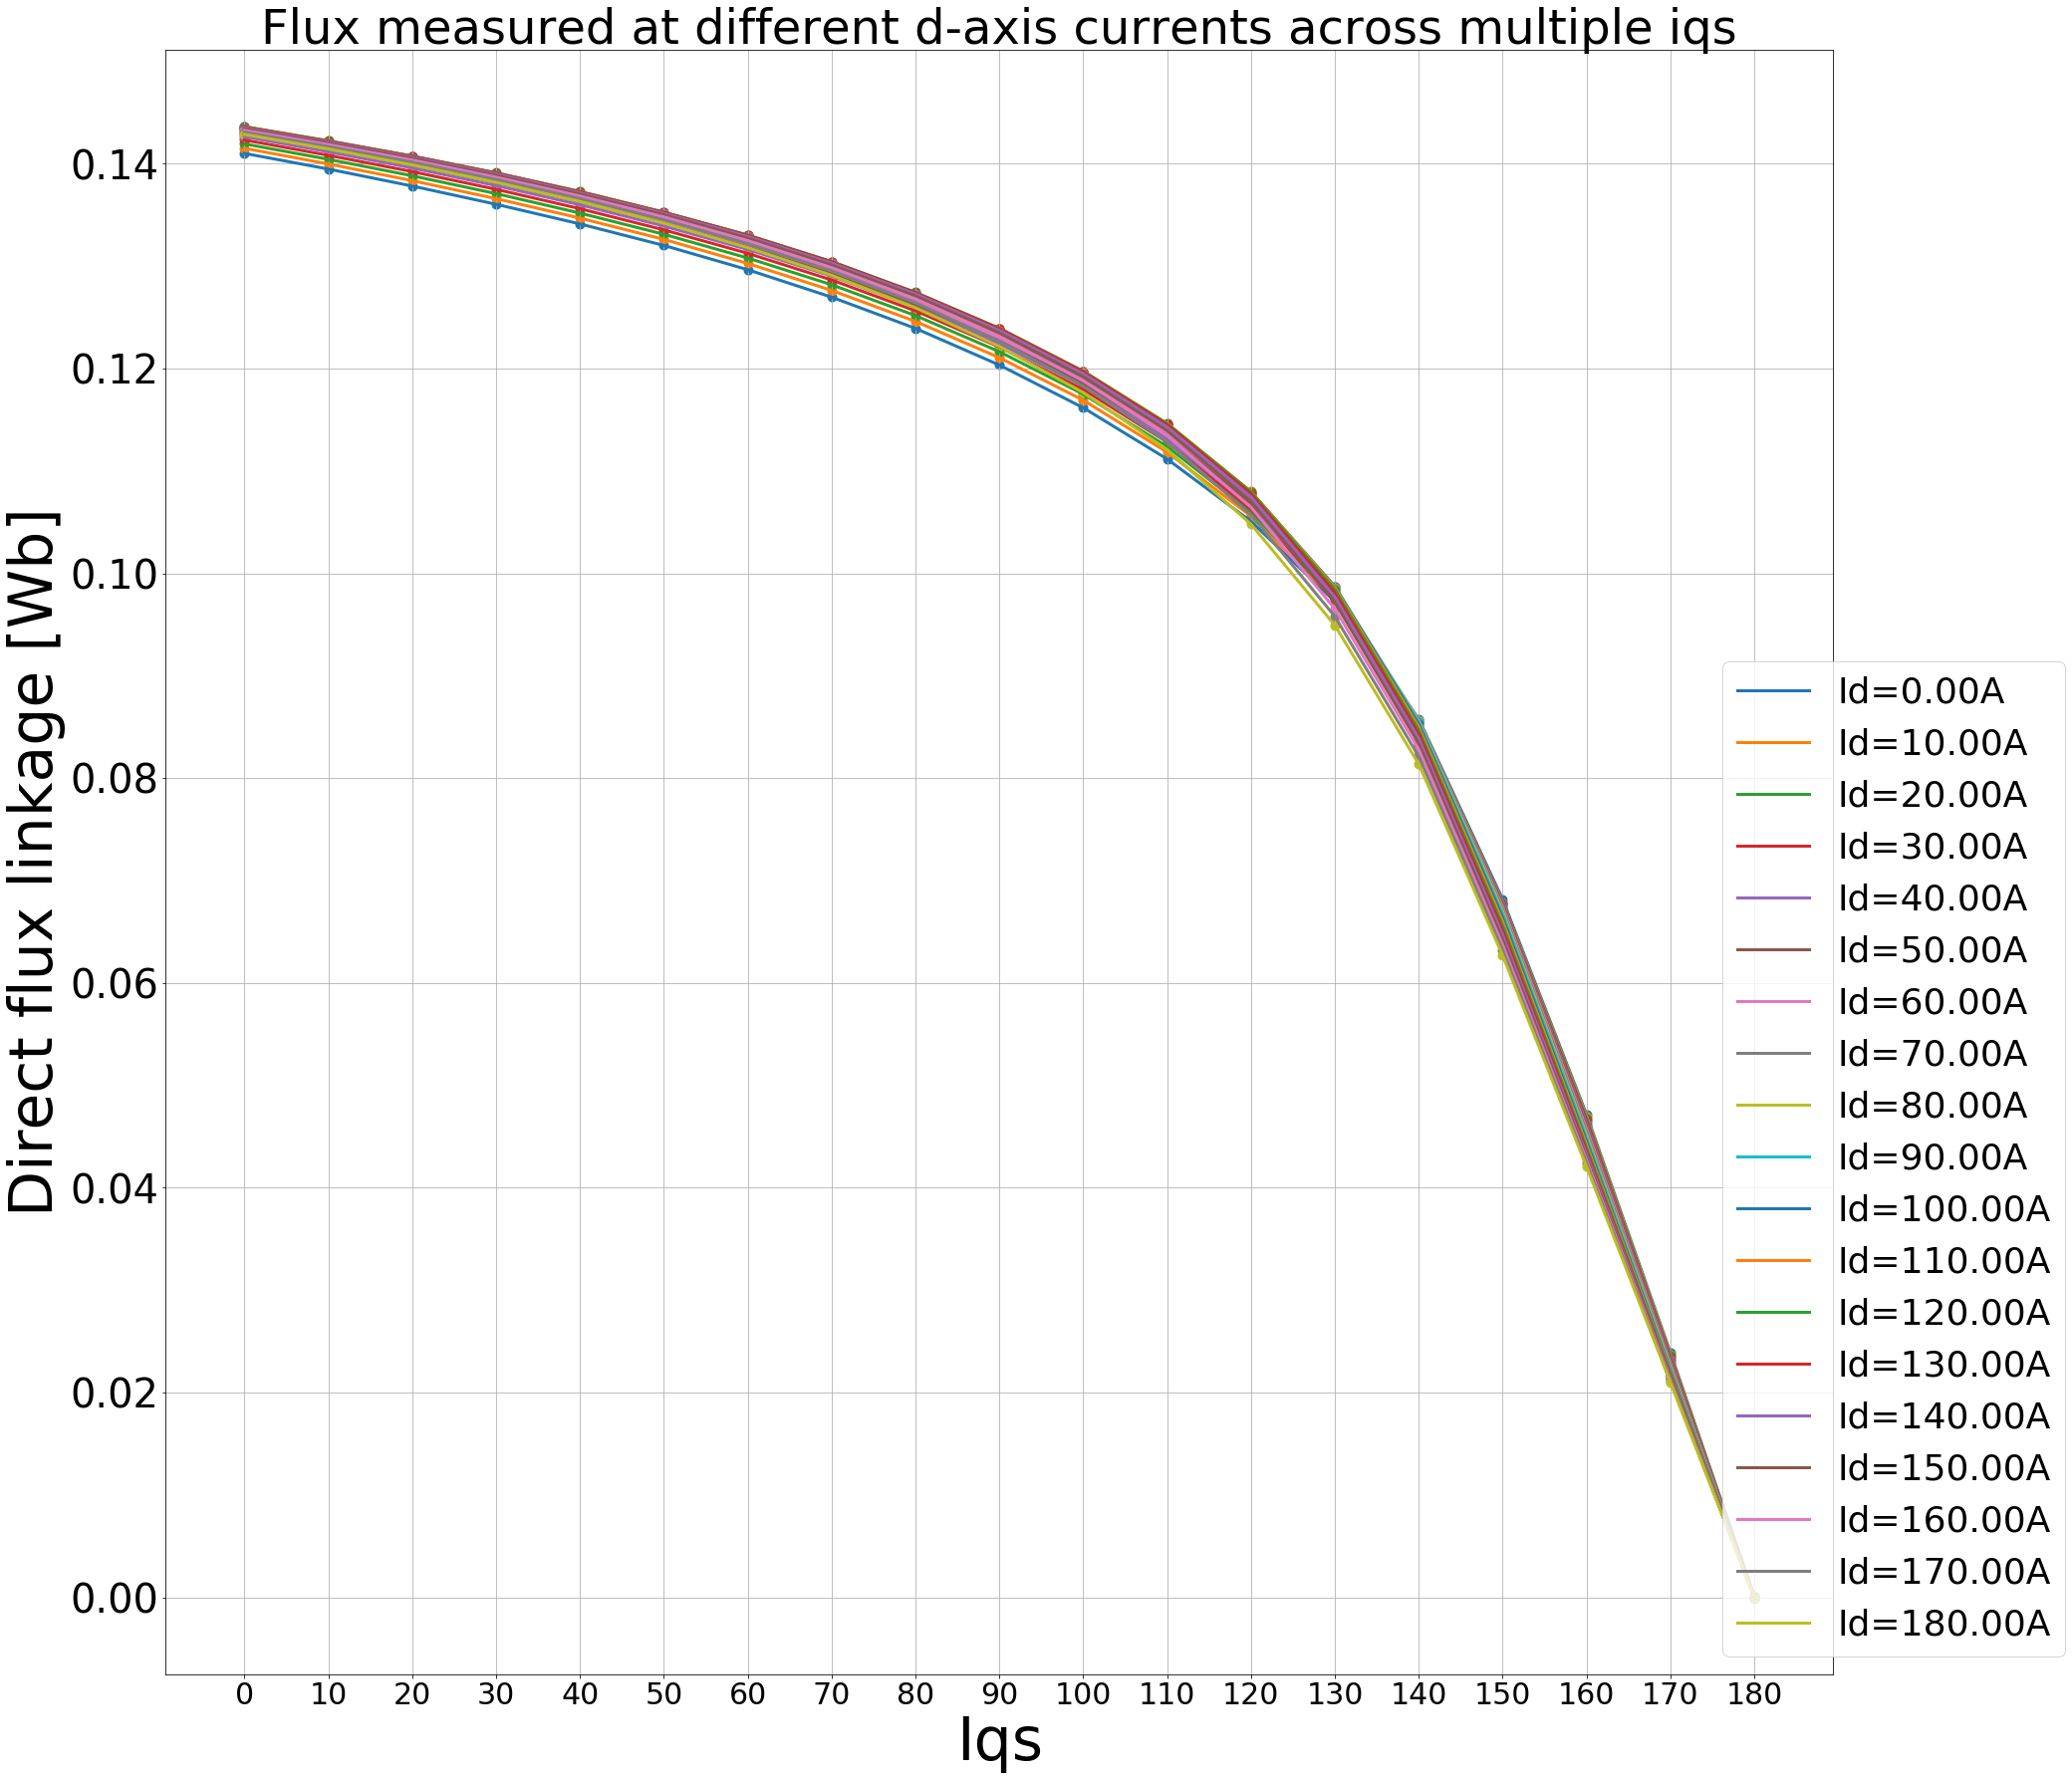

In [28]:
from subprocess import call

flux = np.transpose(np.copy(dfs))

plt.figure(figsize=[30,30])

for idx, current  in enumerate(ids):
    df =flux[idx, :]
    plt.plot(iqs, df, linewidth=3, label='Id=%0.2fA' %(current))
    plt.scatter(iqs, df, linewidths=4)
    plt.xticks(iqs, fontsize=30)
    plt.yticks(fontsize=40)
    plt.xlabel("Iqs", fontsize = 60)
#     plt.locator_params(axis='x', nbins=len(ids))
    plt.ylabel(yLabel, fontsize = 60)
    plt.title('Flux measured at different d-axis currents across multiple iqs', fontsize=48)
    plt.legend(bbox_to_anchor=(1.15, 0), loc='lower right', ncol=1, fontsize=36)
plt.grid()
plt.savefig('test_output/SRM_original_curves_across_iqs.pdf', dpi = 300)
plt.show()

# [REDUCE ANGLES] Use PCA to reduce the number of Ox points (curents)

- observed variable: flux at a specific angle 

- sample: given a current, measure flux value at different iqs; we are oblivious of the current under which the measurement was made; this descripition indicates only how all the samples were collected

- X.shape: (currents, iqs)

- what we want: determine iqs with highest variance (this what PCA does) across all currents



# [REDUCE ANGLES] Plot reconstruction error of PCA as a function of different number of components

components shape (13, 19)


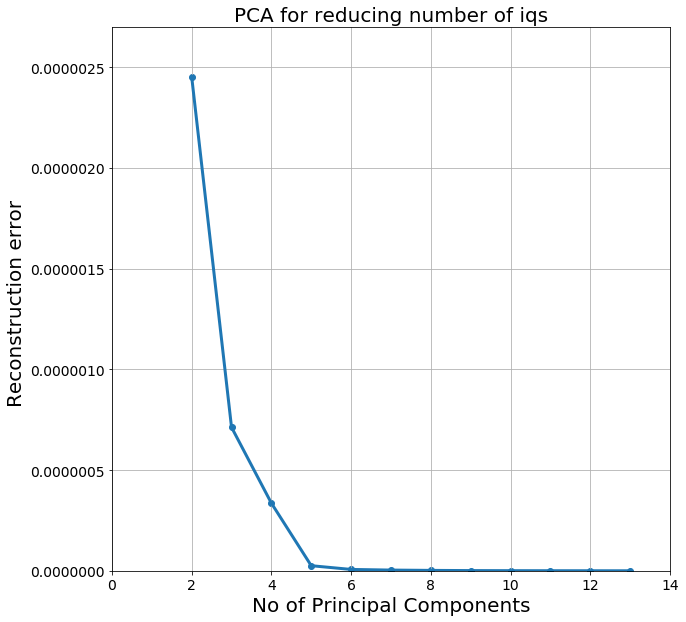

In [7]:
#
import numpy as np
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing

#preprocess the data
X = np.transpose(np.copy(dfs))
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(X)

no_of_comps = range(2, 14)

errors = []
for comp in no_of_comps:
    pca_reduce_points = PCA(n_components=comp)
    flux_reduced = pca_reduce_points.fit_transform(df_flux_scaled)
    projected  = pca_reduce_points.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)
    errors.append(np.sum((projected_unscaled - X) ** 2))
print('components shape', pca_reduce_points.components_.shape)

plt.figure(figsize=(10, 10))
plt.xlabel('No of Principal Components', fontsize = 20)
plt.ylabel('Reconstruction error ', fontsize = 20)
plt.xlim([0,14])
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.locator_params(axis='x', nbins=len(no_of_comps))
plt.scatter(no_of_comps, errors)
plt.plot(no_of_comps, errors, linewidth=3)
plt.grid()
plt.title('PCA for reducing number of iqs', fontsize=20)
plt.savefig('test_output/SRM_reduce_iqs_errors_PCA.pdf', dpi = 300)
plt.show()


# [REDUCE ANGLES] Find iqs - highest variance and choose top n
- Alegem sa zicem 6. tu stii din plotul de mai sus ca 6 unghiuri iti dau eroare de reconstructie suficienta
- Am avut nevoie de PCA ca sa imi aleg n, avand o imagine despre cat o sa pierd

In [29]:
from sklearn.linear_model import Ridge
from pandas import DataFrame as df

X = np.transpose(np.copy(dfs))
variance = np.var(X, axis=0)

iqs_variance = sorted(zip(iqs, variance), key=lambda e : e[1], reverse=True)
border_iqs = [e for e in iqs_variance if e[0] == min(iqs)] + [e for e in iqs_variance if e[0] == max(iqs)]
non_border_iqs = [e for e in iqs_variance if e not in border_iqs]

def get_top_iqs(iqs_no):
    top_iqs = sorted([e[0] for e in iqs_variance[:iqs_no]])
    return top_iqs

def get_top_iqs_bordered(iqs_no):
    assert(iqs_no >= 2)
    top_iqs = border_iqs + non_border_iqs[:iqs_no-2]
    return sorted([e[0] for e in top_iqs])

top_n = range(2, len(iqs))
print('ANGLES WITH HIGHEST VARIANCE')
for n in top_n:
    top_n_iqs = get_top_iqs(n)
    print('top %2d iqs' % n, top_n_iqs)
print('\n')

print('ANGLES WITH HIGHEST VARIANCE -- always including max/min (0, 30)) -- because spline needs limit values')
for n in top_n:
    top_n_iqs = get_top_iqs_bordered(n)
    print('top %2d iqs' % n, top_n_iqs)


ANGLES WITH HIGHEST VARIANCE
top  2 iqs [150, 160]
top  3 iqs [140, 150, 160]
top  4 iqs [110, 140, 150, 160]
top  5 iqs [100, 110, 140, 150, 160]
top  6 iqs [90, 100, 110, 140, 150, 160]
top  7 iqs [90, 100, 110, 120, 140, 150, 160]
top  8 iqs [90, 100, 110, 120, 130, 140, 150, 160]
top  9 iqs [80, 90, 100, 110, 120, 130, 140, 150, 160]
top 10 iqs [70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
top 11 iqs [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
top 12 iqs [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
top 13 iqs [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
top 14 iqs [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
top 15 iqs [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
top 16 iqs [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
top 17 iqs [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
top 18 iqs [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 

# [REDUCE ANGLES] We measure the flux value in key top n iqs and then use linear interpolation to predict flux across all iqs 
- la fel folosesti interpolare liniara pentru ca ai shape neregulat -- multe trepte, schimbari random
- plot Interpolation error as a function of the number of points used as basis per each curve
- we expect to get the same shape like in PCA reconstruction (first plot)

(19, 19)
COMPARE INTERPOLATION WITH/ WITHOUT DEFINED BORDERS


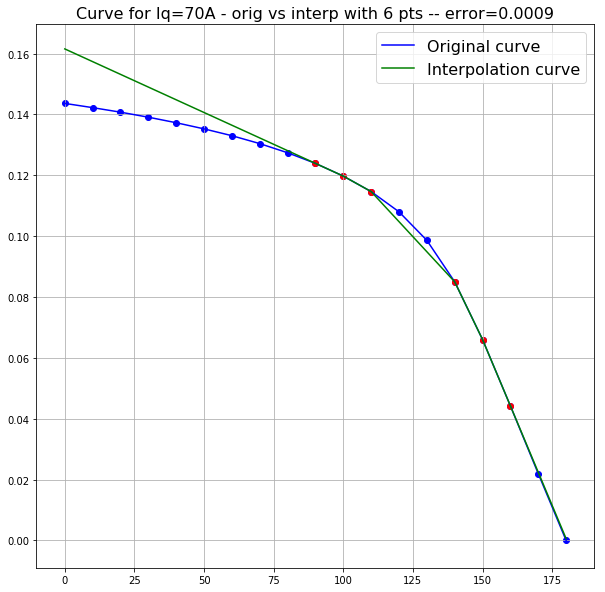

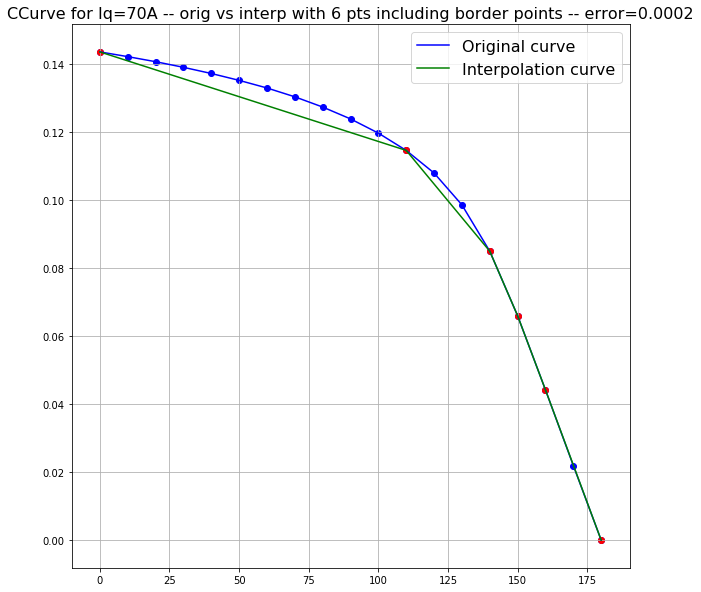

COMPARE INTERPOLATION WITH DIFF NUMBER of POINTS as basis


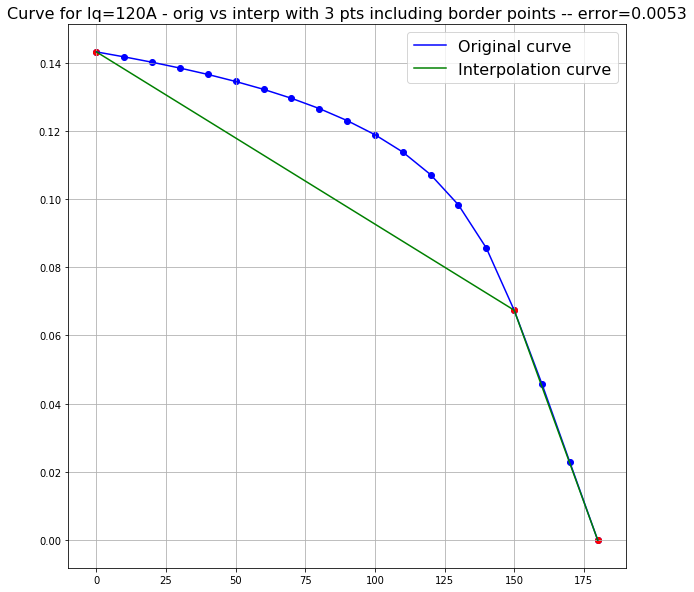

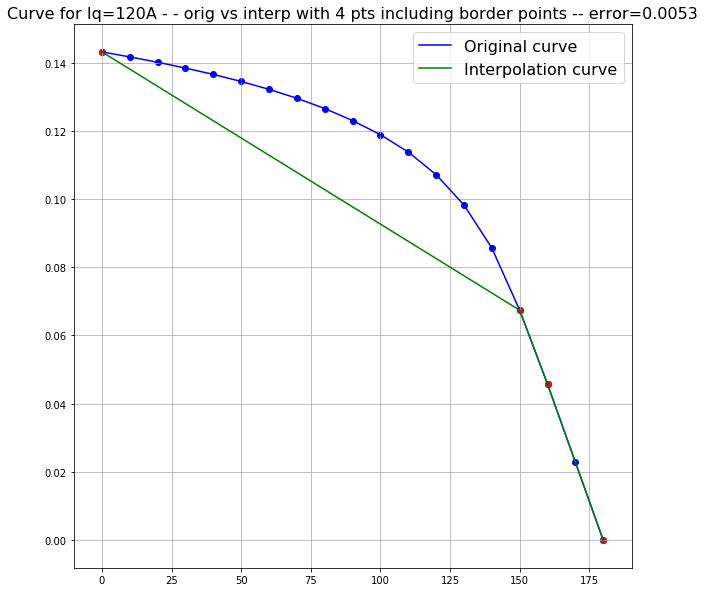

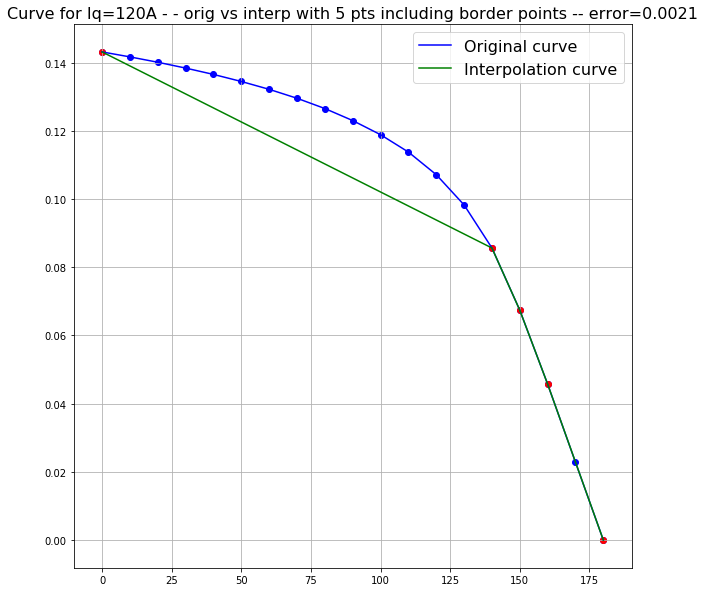

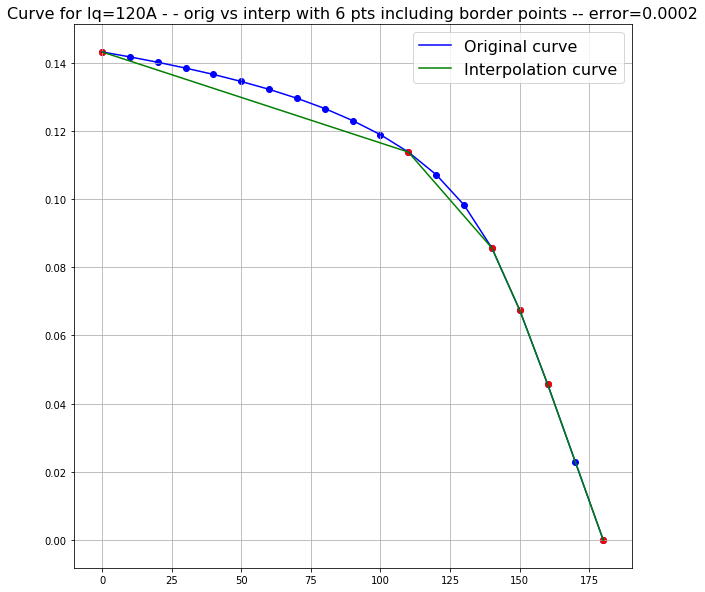

0.00016905129274982043

In [30]:
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy.interpolate import CubicSpline
import itertools
import sys
from pandas import DataFrame as df

X = np.transpose(np.copy(dfs))
print(X.shape)

def get_index(vec, e):
    for i in range(len(vec)):
        if e == vec[i]:
            return i
    assert(False)

def compare_curve_with_interp(curve, n, top_n_function, title):
    top_n_iqs = top_n_function(n)
    top_n_iqs_indices = [get_index(iqs, c) for c in top_n_iqs]
    plt.figure(figsize=(10, 10))
    x = iqs 
    baseline = X[curve, :] 
    plt.plot(x, baseline, c='b', label = 'Original curve')
    plt.scatter(x, baseline, c='b')
    x_ = top_n_iqs
    y_ = X[curve, top_n_iqs_indices]
    tck_ = interpolate.splrep(x_, y_, k=1)
    y = interpolate.splev(x, tck_) 
    error = np.sum((y - baseline)**2)
    
     ## preprocess the title for the saved graphic file
    tmp = top_n_function.__name__
    ana = tmp.split('_')
    if ana[-1] == 'bordered':
        flag = 'with_border_points'
    else:
        flag = 'no_border_points'
    
    plt.scatter(x_, y_, c='r')
    plt.grid()
    plt.plot(x, y, c='g', label = 'Interpolation curve')
    plt.title('%s -- error=%.4f' % (title, error), fontsize=16)
    plt.legend(loc='best', fontsize = 16)
    plt.savefig('test_output/SRM_reduce_iqs_interp_α=%d°_%d_pts_%s' %(curve, n, flag))
    plt.show()
    return error

print('COMPARE INTERPOLATION WITH/ WITHOUT DEFINED BORDERS')
n = 6
curve = 11
compare_curve_with_interp(curve, n, get_top_iqs, 
                                       'Curve for Iq=%dA - orig vs interp with %d pts' % (iqs[curve], n))
compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
                                       'CCurve for Iq=%dA -- orig vs interp with %d pts including border points' % (iqs[curve], n))


print('COMPARE INTERPOLATION WITH DIFF NUMBER of POINTS as basis')

n = 3
curve = 6
compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
                                       'Curve for Iq=%dA - orig vs interp with %d pts including border points' % (iqs[curve], n))
n = 4
compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
                                       'Curve for Iq=%dA - - orig vs interp with %d pts including border points' % (iqs[curve], n))
n = 5
compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
                                       'Curve for Iq=%dA - - orig vs interp with %d pts including border points' % (iqs[curve], n))
n = 6
compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
                                       'Curve for Iq=%dA - - orig vs interp with %d pts including border points' % (iqs[curve], n))


# [REDUCE ANGLES] Plot reconstruction Error of Interpolation

(19, 19)


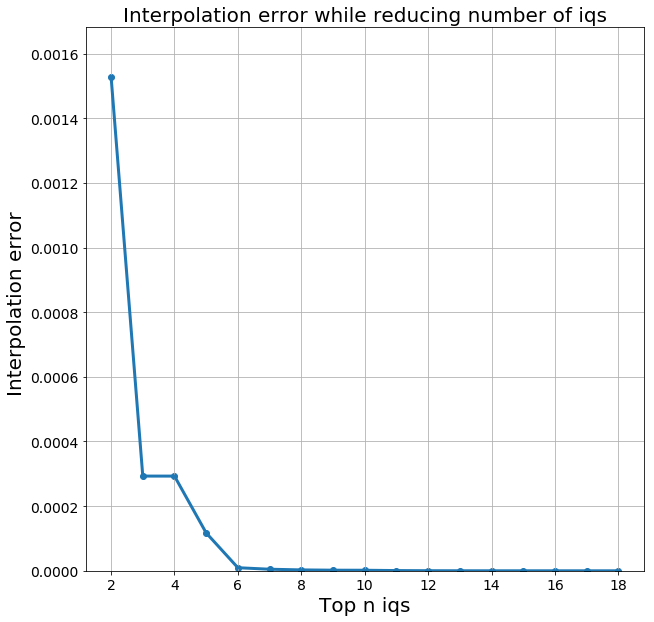

In [25]:
from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from pandas import DataFrame as df

X = np.transpose(np.copy(Flux))
print(X.shape)

top_n = range(2, len(iqs))
errors = []
for n in top_n:
    top_n_iqs = get_top_iqs_bordered(n)
    top_n_iqs_indices = [get_index(iqs, c) for c in top_n_iqs]
    error = 0
    for curve in range(X.shape[0]):
        # baseline = y values obtained when interpolating with all ground truth points
        x = iqs 
        baseline = X[curve, :] 

        # interpolate with top_n_currents as basis 
        x_ = top_n_iqs
        y_ = X[curve, top_n_iqs_indices]
        tck_ = interpolate.splrep(x_, y_, k=1)
        y = interpolate.splev(x, tck_) 
        
        # error -- difference between baseline interp curve and current one
        error += np.sum((baseline - y)**2) /  baseline.shape[0]
    errors.append(error / X.shape[0])
            
plt.figure(figsize=(10, 10))
plt.xlabel('Top n iqs', fontsize = 20)
plt.ylabel('Interpolation error ', fontsize = 20)
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.locator_params(axis='x', nbins=len(top_n))
plt.scatter(top_n, errors)
plt.plot(top_n, errors, linewidth=3)
plt.grid()
plt.title('Interpolation error while reducing number of iqs', fontsize=20)
# plt.savefig('test_output/SRM_reduce_iqs_errors_interp_Spline.pdf', dpi = 200)
# plt.show()



(19, 19)


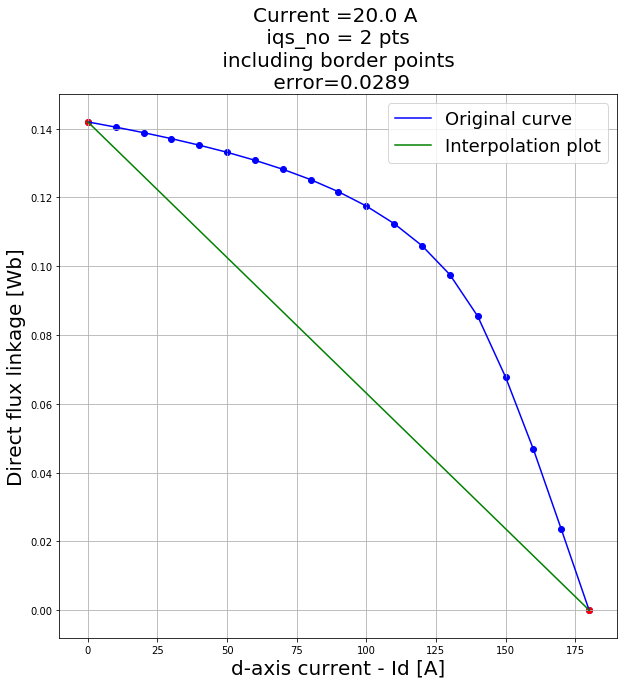

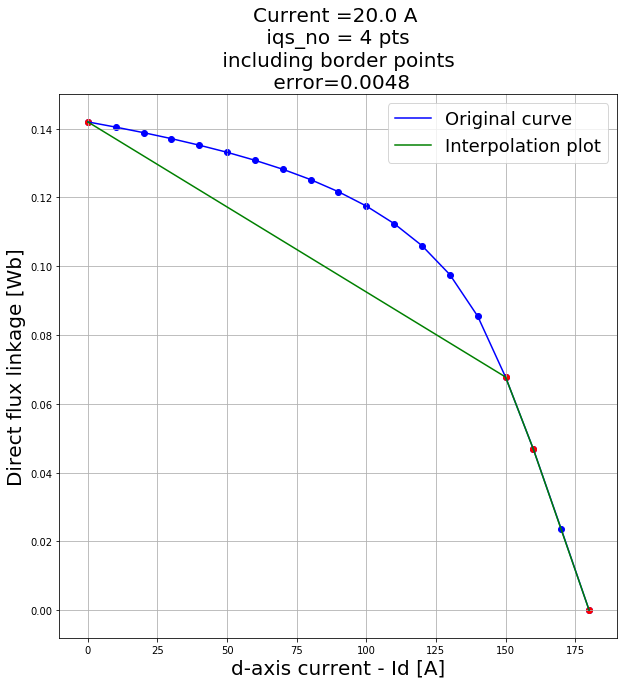

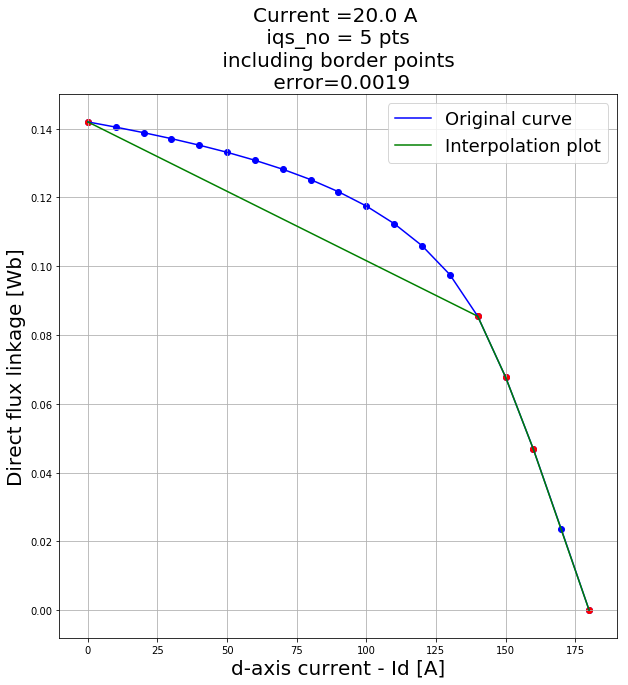

0.0018699977166397694

In [24]:
from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from subprocess import call
from pandas import DataFrame as df

X = np.transpose(np.copy(Flux))
print(X.shape)
# print(X.shape)

#initialize plot size
# plt.figure(figsize=[30,30])
# plt.rcParams['figure.figsize'] = (30,30)

def get_index(vec, e):
    for i in range(len(vec)):
        if e == vec[i]:
            return i
    assert(False)

def compare_curve_with_interp(curve, n, top_n_function, title):
    top_n_iqs = top_n_function(n)
    top_n_iqs_indices = [get_index(iqs, c) for c in top_n_iqs]
    plt.figure(figsize=(10, 10))
    x = iqs 
    baseline = X[curve, :] 
    plt.plot(x, baseline, c='b', label = 'Original curve')
    plt.scatter(x, baseline, c='b')
    x_ = top_n_iqs
    y_ = X[curve, top_n_iqs_indices]
    tck_ = interpolate.splrep(x_, y_, k=1)
    y = interpolate.splev(x, tck_) 
    error = np.sum((y - baseline)**2)
       
          
    ## preprocess the title for the saved graphic file
    tmp = top_n_function.__name__
    ana = tmp.split('_')
    if ana[-1] == 'bordered':
        flag = 'with_border_points'
    else:
        flag = 'no_border_points'
       
    plt.scatter(x_, y_, c='r')
    plt.plot(x, y, c='g', label = 'Interpolation plot')
    plt.title('%s \n error=%.4f' % (title, error), fontsize=20)
    plt.xlabel(xLabel, fontsize = 20)
    plt.ylabel(yLabel, fontsize = 20)
    plt.legend(loc='best', fontsize = 18)
    plt.grid()
    plt.savefig('test_output/SRM_reduce_iqs_interp_current=%0.1f_A_%d_pts_%s.pdf' %(ids[curve], n, flag))
    plt.show()
    return error

# print('COMPARE INTERPOLATION WITH/ WITHOUT DEFINED BORDERS')
# n = 15
# curve = 2
# compare_curve_with_interp(curve, n, get_top_iqs, 
#                 'α=%d° \n currents_no = %d pts \n NO including border points' % (curve, n))
# compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
#                 'α=%d° \n currents_no = %d pts \n including border points' % (curve, n))


# print('COMPARE INTERPOLATION WITH DIFF NUMBER of POINTS as basis')


n = 2
curve = 2
compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
                'Current =%0.1f A \n iqs_no = %d pts \n including border points' % (ids[curve], n))

n = 4
curve = 2
compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
                'Current =%0.1f A \n iqs_no = %d pts \n including border points' % (ids[curve], n))
n = 5
curve = 2
compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
                'Current =%0.1f A \n iqs_no = %d pts \n including border points' % (ids[curve], n))

# n = 20
# curve = 6
# compare_curve_with_interp(curve, n, get_top_iqs, 
#                 'Current=%0.1f A  \n iqs_no = %d pts \n NO including border points' % (ids[curve], n))

# n = 10
# curve = 6
# compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
#                 'Current=%0.1f A  \n currents_no = %d pts \n including border points' % (ids[curve], n))

# n = 10
# curve = 6
# compare_curve_with_interp(curve, n, get_top_iqs, 
#                 'Current=%0.1f A  \n iqs_no = %d pts \n NO including border points' % (ids[curve], n))
# n = 3
# curve = 6
# compare_curve_with_interp(curve, n, get_top_iqs_bordered, 
#                 'Current=%0.1f A  \n iqs_no = %d pts \n including border points' % (ids[curve], n))

# n = 14
# curve = 6
# compare_curve_with_interp(curve, n, get_top_iqs, 
#                 'Current=%0.1f A  \n iqs_no = %d pts \n NO including border points' % (ids[curve], n))


In [ ]:
print(ids)
print(ids[4])